## Imports

In [312]:
import gc
import logging
import math
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import accuracy_score
from torch.autograd import Variable
from torch.nn import *
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm import tqdm

reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', level=logging.INFO, datefmt='%I:%M:%S')

## Neural Network Classes

In [313]:
class SimpleCNN(Module):
    def __init__(self, config):
        super(SimpleCNN, self).__init__()
        img_dim = config['shape'][2]
        channels = config['shape'][1]
        conv_layers = np.array([
            [LazyConv2d(channels * 3 ** (depth + 1), kernel_size=3, stride=1, padding=1),
             LazyBatchNorm2d(),
             ReLU(inplace=True),
             MaxPool2d(kernel_size=2, stride=2)]
            for depth in range(config['nr_conv_layers'])
        ]).flatten().tolist()
        linear_layers = [
            LazyLinear(max(math.floor(channels * img_dim ** 2 / 2 ** (depth + 1)), channels)) for depth in
            range(config['nr_linear_layers'] - 1)
        ]
        self.layers = Sequential(
            *conv_layers,
            Flatten(start_dim=1),
            *linear_layers,
            LazyLinear(config['labels'])
        )
        logging.info(self.layers)

    def forward(self, x):
        x = self.layers(x)
        return x


class DensePolyNN(Module):
    def __init__(self, config):
        super(DensePolyNN, self).__init__()

        img_dim = config['shape'][2]
        channels = config['shape'][1]
        linear_layers = [
            LazyLinear(max(math.floor(channels * img_dim ** 2 / 2 ** (depth + 1)), channels)) for depth in
            range(config['nr_linear_layers'] - 1)
        ]

        self.layers = Sequential(
            Flatten(start_dim=1),
            *linear_layers,
            LazyLinear(config['labels'])
        )
        logging.info(self.layers)

    def forward(self, x):
        x = self.layers(x)
        return x


class DenseLinearNN(Module):
    def __init__(self, config):
        super(DenseLinearNN, self).__init__()

        img_dim = config['shape'][2]
        channels = config['shape'][1]
        linear_layers = [
            LazyLinear(max(math.floor(
                channels * img_dim ** 2 - (depth + 1) * (channels * img_dim ** 2 / config['nr_linear_layers'])),
                channels)) for depth in range(config['nr_linear_layers'] - 1)]

        self.layers = Sequential(
            Flatten(start_dim=1),
            *linear_layers,
            LazyLinear(config['labels'])
        )
        logging.info(self.layers)

    def forward(self, x):
        x = self.layers(x)
        return x

## Helper functions

In [314]:
def create_model(net, config):
    model = net(config=config)
    optimizer = Adam(model.parameters(), lr=0.005)
    criterion = CrossEntropyLoss()
    if torch.cuda.is_available():
        logging.info('Using GPU')
        model = model.cuda()
        criterion = criterion.cuda()
    return model, optimizer, criterion


def train(net, config, batches, tag):
    logging.info(f'Constructing {tag}')
    model, optimizer, criterion = create_model(net, config)
    train_losses = []
    logging.info('Training the model')
    for _ in tqdm(range(config['epochs'])):
        for batch_id, batch in batches:
            train_x = batch[0]
            train_y = batch[1]
            model.train()
            x_train, y_train = Variable(train_x), Variable(train_y)
            if torch.cuda.is_available():
                x_train = x_train.cuda()
                y_train = y_train.cuda()

            # clearing the Gradients of the model parameters
            optimizer.zero_grad()

            # prediction for training set
            output_train = model(x_train)

            # computing the training loss
            loss_train = criterion(output_train, y_train)
            train_losses.append(loss_train.item())

            # computing the updated weights of all the model parameters
            loss_train.backward()
            optimizer.step()
    plt.plot(train_losses, label='Training loss')
    plt.yscale('log')
    plt.legend()
    plt.show()
    return model


def test(model, test_x, test_y):
    with torch.no_grad():
        output = model(test_x.cuda())

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)

    return accuracy_score(test_y, predictions)


def predict(model, test_x, predictions):
    logging.info('Generating predictions')
    with torch.no_grad():
        output = model(test_x.cuda())

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions['label'] = np.argmax(prob, axis=1)
    return predictions

## Configuration

In [315]:
config = {
    'epochs': 25,
    'nr_linear_layers': 3,
    'nr_conv_layers': 4,
    'batch_size': 512,
    'dataset': datasets.FashionMNIST
}

## Load data

In [316]:
logging.info('Loading data...')
training_data = config['dataset'](
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
train_dataloader = DataLoader(training_data, batch_size=config['batch_size'], shuffle=True)
batches = [(batch_id, batch) for batch_id, batch in enumerate(train_dataloader)]
logging.info('Training data loaded')

test_data = config['dataset'](
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
test_x, test_y = next(iter(test_dataloader))
logging.info('Test data loaded')
config['shape'] = batches[0][1][0].shape
config['labels'] = len(training_data.classes)

02:04:44 INFO: Loading data...


Files already downloaded and verified


02:04:50 INFO: Training data loaded


Files already downloaded and verified


02:04:51 INFO: Test data loaded


## Train model

02:04:52 INFO: Constructing DenseLinearNN
/home/yarally1/.local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
02:04:52 INFO: Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): LazyLinear(in_features=0, out_features=2048, bias=True)
  (2): LazyLinear(in_features=0, out_features=1024, bias=True)
  (3): LazyLinear(in_features=0, out_features=10, bias=True)
)
02:04:52 INFO: Using GPU
02:04:52 INFO: Training the model
100%|██████████| 50/50 [00:37<00:00,  1.34it/s]


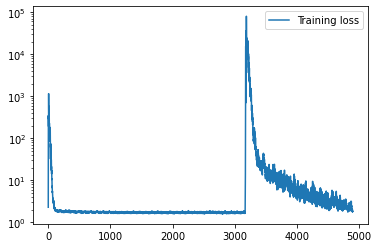

02:05:29 INFO: Constructing DensePolyNN
02:05:29 INFO: Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): LazyLinear(in_features=0, out_features=1536, bias=True)
  (2): LazyLinear(in_features=0, out_features=768, bias=True)
  (3): LazyLinear(in_features=0, out_features=10, bias=True)
)
02:05:29 INFO: Using GPU
02:05:29 INFO: Training the model
100%|██████████| 50/50 [00:28<00:00,  1.75it/s]


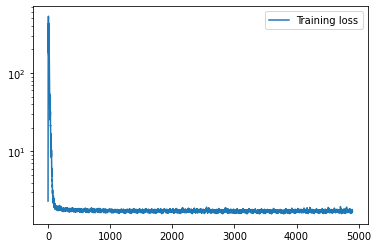

02:05:58 INFO: Constructing SimpleCNN
02:05:58 INFO: Sequential(
  (0): LazyConv2d(0, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): LazyConv2d(0, 27, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): LazyConv2d(0, 81, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): LazyConv2d(0, 243, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): LazyBatchNorm2d(0, eps=1e-

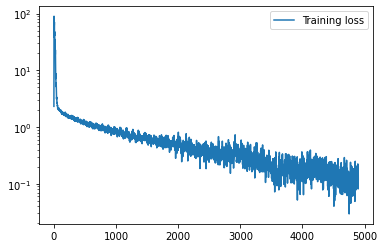

In [317]:
torch.manual_seed(42)
gc.collect()
torch.cuda.empty_cache()
models = [
    (train(DenseLinearNN, config, batches, 'DenseLinearNN'), 'DenseLinearNN'),
    (train(DensePolyNN, config, batches, 'DensePolyNN'), 'DensePolyNN'),
    (train(SimpleCNN, config, batches, 'SimpleCNN'), 'SimpleCNN'),
]
gc.collect()
torch.cuda.empty_cache()

## Test Model

In [318]:
logging.info('Generating predictions and calculating accuracy')
for model, tag in models:
    accuracy = test(model, test_x, test_y)
    logging.info(f'{tag}: {accuracy=}')

02:07:09 INFO: Generating predictions and calculating accuracy
02:07:10 INFO: DenseLinearNN: accuracy=0.2497
02:07:10 INFO: DensePolyNN: accuracy=0.375
02:07:10 INFO: SimpleCNN: accuracy=0.6811
